Loading database for feasibility test...
Feasibility sample created with 45 target polygons.


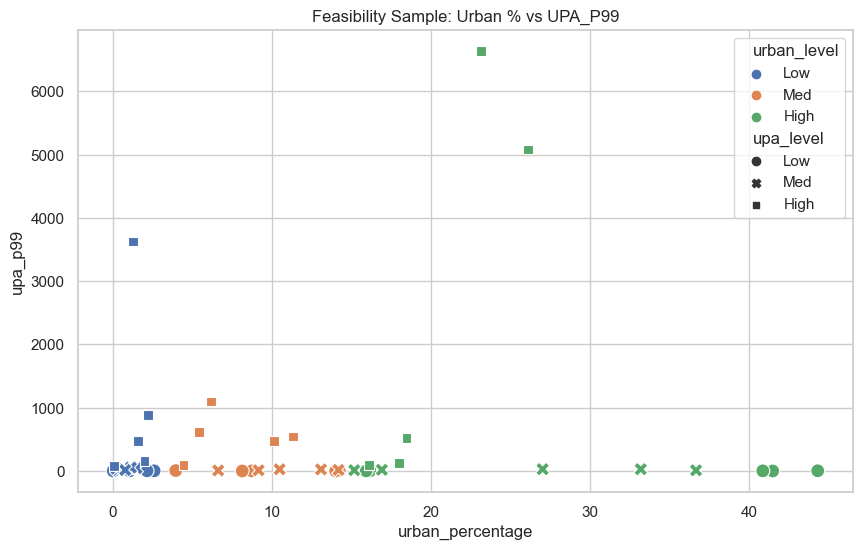

C:\Users\raznu\AppData\Local\Temp\ipykernel_26972\3107370354.py:50: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
C:\Users\raznu\AppData\Local\Temp\ipykernel_26972\3107370354.py:53: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test.centroid.plot(ax=ax, color='red', markersize=50, label='Test Targets')


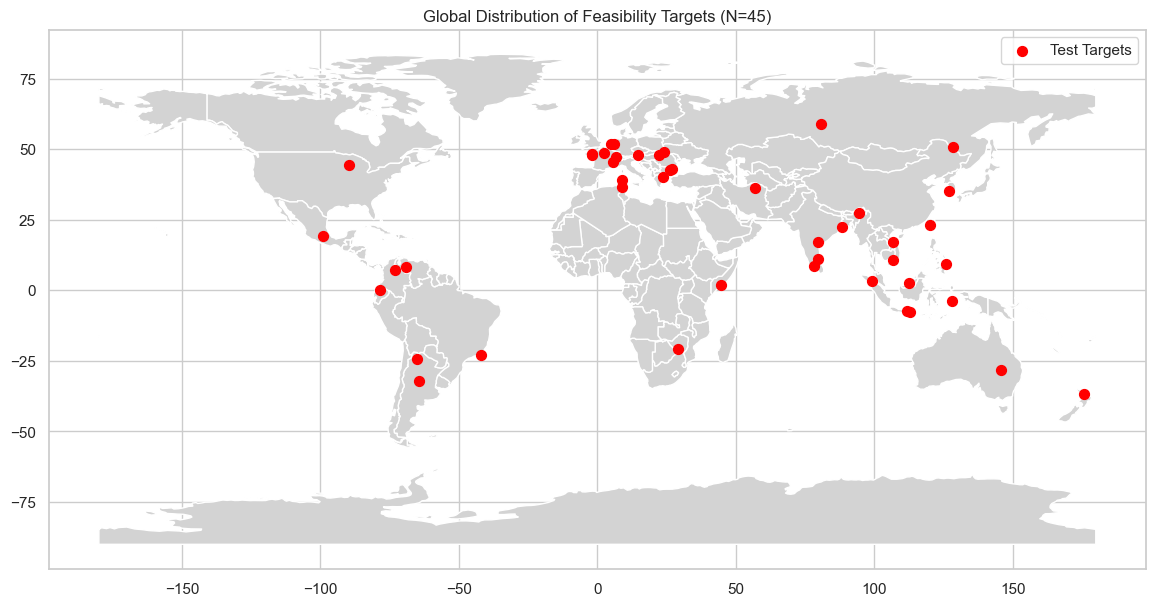


--- Detailed View of the First 10 Test Targets ---


,event_id,urban_percentage,upa_p99,urban_level,upa_level
0,371869,2.589702,2.423245,Low,Low
1,464044,0.046098,1.217783,Low,Low
2,433165,0.017014,1.289664,Low,Low
3,377529,2.144388,2.725303,Low,Low
4,400983,1.049562,2.005231,Low,Low
5,253586,1.484718,45.816540,Low,Med
6,350940,0.308536,14.951337,Low,Med
7,506534,1.132221,53.918299,Low,Med
8,239880,0.208037,37.111780,Low,Med
9,406360,0.771212,14.960483,Low,Med


In [6]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import shapely.wkt

# --- NOTEBOOK SETTINGS ---
%matplotlib inline
sns.set_theme(style="whitegrid")

# --- CONFIGURATION ---
CHRONICLE_DB_PATH = r"D:\Development\RESEARCH\urban_flood_database\chronicle\imerg_rain_outputs\chronicle_urban_df_with_IMERG_FULL.pkl"
MODERN_ERA_START = "2018-01-01"

# 1. Load a portion of the database for the test
print(f"Loading database for feasibility test...")
chronicle_df = pd.read_pickle(CHRONICLE_DB_PATH)

# Ensure datetime format
if not pd.api.types.is_datetime64_any_dtype(chronicle_df['start_time']):
    chronicle_df['start_time'] = pd.to_datetime(chronicle_df['start_time'], unit='s')

# Filter for the Modern Era
modern_events_df = chronicle_df[chronicle_df['start_time'] >= MODERN_ERA_START].copy()

# 2. Stratification Logic (Small Scale)
# Creating 3x3 buckets based on quantiles
modern_events_df['urban_level'] = pd.qcut(modern_events_df['urban_percentage'], 3, labels=['Low', 'Med', 'High'])
modern_events_df['upa_level'] = pd.qcut(modern_events_df['upa_p99'], 3, labels=['Low', 'Med', 'High'])

# FEASIBILITY SAMPLE: Pick only 5 polygons per bucket
test_targets_df = modern_events_df.groupby(['urban_level', 'upa_level']).apply(
    lambda x: x.sample(n=min(len(x), 5), random_state=42)
).reset_index(drop=True)

print(f"Feasibility sample created with {len(test_targets_df)} target polygons.")

# 3. Visualizing the Sample Distribution
plt.figure(figsize=(10, 6))
sns.scatterplot(data=test_targets_df, x='urban_percentage', y='upa_p99', hue='urban_level', style='upa_level', s=100)
plt.title("Feasibility Sample: Urban % vs UPA_P99")
plt.show()

# 4. Global Mapping (Small Scale)
test_targets_df['geometry'] = test_targets_df['geometry_wkt'].apply(shapely.wkt.loads)
gdf_test = gpd.GeoDataFrame(test_targets_df, geometry='geometry', crs="EPSG:4326")

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
fig, ax = plt.subplots(figsize=(15, 7))
world.plot(ax=ax, color='lightgrey', edgecolor='white')
gdf_test.centroid.plot(ax=ax, color='red', markersize=50, label='Test Targets')
plt.title("Global Distribution of Feasibility Targets (N=45)")
plt.legend()
plt.show()

# 5. Inspect the data
print("\n--- Detailed View of the First 10 Test Targets ---")
display(test_targets_df[['event_id', 'urban_percentage', 'upa_p99', 'urban_level', 'upa_level']].head(45))